### Load package

In [ ]:
# Install package first
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

## if there seems to be inconsistency due to numpy & pandas versions, do the following
!uv pip uninstall pandas numpy
!uv pip install -q --force-reinstall numpy==1.26.4 --system
!uv pip install -q --force-reinstall pandas==2.2.2 --system

## You may need to restart colab kernel

Using Python 3.11.11 environment at: /usr
Uninstalled 2 packages in 156ms
 - numpy==1.26.4
 - pandas==2.2.2


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance

/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance


### Modify data format

In [ ]:
import pandas as pd

# Load the Excel file
file_path = "Chronos_PdM_threshold_exced.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None)  # Read all sheets

# Dictionary to store modified sheets
modified_sheets = {}

for sheet_name, df in all_sheets.items():
    # Rename the second column to "target"
    df.columns = ['timestamp', 'target']  # Assume the original second column was the variable

    # Add "item_id" column as the first column
    df.insert(0, 'item_id', 1)

    # Rename "datetime" to "timestamp" and format it as "%Y-%m-%d %H:%M:%S"
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

    # Store modified DataFrame
    modified_sheets[sheet_name] = df

# Save the modified data into a new Excel file
output_file = "Chronos_PdM_threshold_exced_reformat.xlsx"

with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in modified_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Processing complete. Saved as 'Chronos_PdM_threshold_exced_reformat.xlsx'.")

Processing complete. Saved as 'Chronos_PdM_threshold_exced_reformat.xlsx'.


### Do the task now, model evaluation metrics & threshold exceedance accuracy are stored in xlsx sheet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Define prediction length
prediction_length = 100

# Load the dataset (assuming it's in an Excel file with 100 sheets)
file_path = "Chronos_PdM_threshold_exced_reformat.xlsx"
all_series = pd.read_excel(file_path, sheet_name=None, parse_dates=True)

#### Chronos Blot_small

In [ ]:
# Data storage for evaluation metrics and accuracy results
leaderboard_results = []
accuracy_results = []

# Loop over all 100 time series
for series_name, data in all_series.items():
    print(f"Processing {series_name}...")

    # Convert to TimeSeriesDataFrame
    data = TimeSeriesDataFrame.from_data_frame(data)

    # Split data into train and test sets
    train_data, test_data = data.train_test_split(prediction_length)

    # Train the Chronos model
    predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
        train_data, presets="bolt_small"
    )

    # Generate predictions
    predictions = predictor.predict(train_data)

    # Evaluate the model using multiple metrics
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAPE', 'MAE', 'MSE', 'RMSE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', series_name)  # Add time series identifier
    leaderboard_results.append(leaderboard_df)

    # Extract prediction mean values and actual values
    yhat1 = predictions['mean']
    y1 = test_data['target']
    result_df = pd.merge(yhat1, y1, how='outer', left_index=True, right_index=True)
    result_df.columns = ['yhat1', 'y1']

    # Compute the threshold based on mean and standard deviation
    mean_value = np.mean(result_df.y1)
    std_value = np.std(result_df.y1)
    threshold = mean_value + 2 * std_value

    # Calculate threshold exceedance for predictions and actual values
    predicted_exceedance = result_df.yhat1 > threshold
    true_exceedance = result_df.y1 > threshold

    # Compute accuracy of threshold exceedance prediction
    accuracy = accuracy_score(true_exceedance, predicted_exceedance)

    # Store accuracy results
    accuracy_results.append({'time_series': series_name, 'accuracy': accuracy})

# Save leaderboard results to an Excel file
leaderboard_results_df = pd.concat(leaderboard_results, ignore_index=True)
leaderboard_file = "Chronos_thre_exced_Leaderboard_Results_bolt_small.xlsx"
leaderboard_results_df.to_excel(leaderboard_file, index=False)

# Save accuracy results to an Excel file
accuracy_results_df = pd.DataFrame(accuracy_results)
# accuracy_file = "Chronos_thre_exced_Accuracy.xlsx"
accuracy_file = "Chronos_thre_exced_Accuracy_temp.xlsx"
accuracy_results_df.to_excel(accuracy_file, index=False)

print("Processing complete! Results saved.")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153452'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.13 GB / 12.67 GB (80.0%)
Disk Space Avail:   60.95 GB / 107.72 GB (56.6%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}



Processing Machine_1...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:34:52
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.16 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_2...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:34:55
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.19 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_3...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:34:57
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.19 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_4...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:00
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_5...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:02
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.18 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_6...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.15 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive

Processing Machine_7...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:07
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.18 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive

Processing Machine_8...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:09
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_9...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:11
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.18 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_10...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:14
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_11...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:16
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.20 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_12...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:19
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive

Processing Machine_13...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:22
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_14...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:25
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.18 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_15...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:27
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_16...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:29
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_17...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:32
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.14 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153534'
==============

Processing Machine_18...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:35
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive

Processing Machine_19...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:37
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.18 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_20...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:39
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.21 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_21...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:41
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.18 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_22...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:44
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.15 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_23...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:47
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.03    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_24...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:50
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_25...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:53
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_26...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:56
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_27...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:35:59
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_28...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:01
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_29...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_30...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:08
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.16 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_31...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:10
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.19 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_32...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:12
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_33...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:15
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_34...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:17
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training run

Processing Machine_35...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.16 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive

Processing Machine_36...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:23
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_37...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:25
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.22 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_38...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:28
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_39...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:30
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.19 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_40...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:33
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.14 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_41...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:35
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.16 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_42...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:37
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_43...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:40
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_44...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:42
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_45...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:45
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training run

Processing Machine_46...


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:49
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries m

Processing Machine_47...


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:52
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries m

Processing Machine_48...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.14 GB / 12.67 GB (80.0%)
Disk Space Avail:   60.93 GB / 107.72 GB (56.6%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following c

Processing Machine_49...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:36:59
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_50...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:01
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_51...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.21 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive

Processing Machine_52...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:07
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.21 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_53...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:10
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.23 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_54...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:13
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_55...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:15
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_56...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:18
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.18 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_57...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.21 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_58...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:23
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.22 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_59...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:25
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.03    s     = Training run

Processing Machine_60...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:28
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_61...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:30
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training run

Processing Machine_62...


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:33
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries m

Processing Machine_63...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:36
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_64...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:39
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_65...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:42
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_66...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:46
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_67...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.34 GB / 12.67 GB (57.9%)
Disk Space Avail:   60.93 GB / 107.72 GB (56.6%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following co

Processing Machine_68...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:54
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_69...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:56
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_70...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:37:59
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_71...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:01
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_72...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_73...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:07
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.20 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_74...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:09
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_75...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:12
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_76...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:15
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.23 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_77...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:17
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_78...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.23 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_79...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:23
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_80...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:25
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.23 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_81...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:28
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_82...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:30
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_83...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:33
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_84...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:36
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_85...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:38
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_86...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:41
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_87...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:43
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_88...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:46
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_89...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:50
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.25 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_90...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:53
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing Machine_91...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:55
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_92...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:38:58
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.27 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_93...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:00
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_94...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:03
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.24 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon

Processing Machine_95...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:06
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_96...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:09
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_97...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:11
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_98...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:14
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.0

Processing Machine_99...


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:17
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries m

Processing Machine_100...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:39:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

Processing complete! Results saved.


#### Chronos Bolt_base

In [ ]:
# Define prediction length
prediction_length = 100

# Note: this Accuracy file is generated by code from Chronos Bolt_small, and is deleted
# after I get all model accuracy, if you want to replicate the result yourself, you can
# run code from above and change file name if necessary.
accuracy_file = "Chronos_thre_exced_Accuracy.xlsx"
accuracy_results_df = pd.read_excel(accuracy_file)

# Load the dataset (assuming it's in an Excel file with 100 sheets)
file_path = "Chronos_PdM_threshold_exced_reformat.xlsx"
all_series = pd.read_excel(file_path, sheet_name=None, parse_dates=True)

In [ ]:
# Data storage for evaluation metrics and accuracy results
leaderboard_results = []
new_accuracy_results = []

# Loop over all 100 time series
for series_name, data in all_series.items():
    print(f"Processing {series_name}.../n")

    # Convert to TimeSeriesDataFrame
    data = TimeSeriesDataFrame.from_data_frame(data)

    # Split data into train and test sets
    train_data, test_data = data.train_test_split(prediction_length)

    # Train the Chronos model
    predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
        train_data, presets="bolt_base"
    )

        # Evaluate leaderboard and save results
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', series_name)  # Add time series identifier
    leaderboard_results.append(leaderboard_df)

    # Extract predictions and actual values
    yhat1 = predictions['mean']
    y1 = test_data['target']
    result_df = pd.merge(yhat1, y1, how='outer', left_index=True, right_index=True)
    result_df.columns = ['yhat1', 'y1']

    # Compute threshold exceedance
    mean_value = np.mean(result_df.y1)
    std_value = np.std(result_df.y1)
    threshold = mean_value + 2 * std_value

    # Compute exceedance accuracy
    predicted_exceedance = result_df.yhat1 > threshold
    true_exceedance = result_df.y1 > threshold
    accuracy = accuracy_score(true_exceedance, predicted_exceedance)

    # Store new accuracy result
    new_accuracy_results.append({'time_series': series_name, 'bolt_base_accuracy': accuracy})

# Convert new accuracy results to DataFrame
new_accuracy_df = pd.DataFrame(new_accuracy_results)

# Merge bolt_base accuracy with the existing accuracy DataFrame
merged_accuracy_df = accuracy_results_df.merge(new_accuracy_df, on='time_series', how='left')

# Save updated accuracy results
updated_accuracy_file = "Chronos_Threshold_Accuracy_Updated.xlsx"
merged_accuracy_df.to_excel(updated_accuracy_file, index=False)

# Save new leaderboard results
leaderboard_results_df = pd.concat(leaderboard_results, ignore_index=True)
leaderboard_file = "Chronos_thre_exced_Leaderboard_Results_bolt_base.xlsx"
leaderboard_results_df.to_excel(leaderboard_file, index=False)

print("Processing complete! Updated accuracy results and new leaderboard saved.")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152606'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.28 GB / 12.67 GB (81.1%)
Disk Space Avail:   61.69 GB / 107.72 GB (57.3%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred t

Processing Machine_1.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:06
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152617'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.25 GB / 12.67 GB (80.9%)
Disk Space Avail:   60.97 GB / 107.72 GB (56.6%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred t

Processing Machine_2.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:17
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.09 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152620'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_3.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:20
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152622'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_4.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:23
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152625'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_5.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:25
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.09 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152628'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_6.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:28
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.09 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152631'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_7.../n


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:31
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152634'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:    

Processing Machine_8.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:34
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152637'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_9.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:37
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.10 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152639'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_10.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:39
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152642'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_11.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:42
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.10 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152645'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_12.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:45
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.03    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152648'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_13.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:48
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.10 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152651'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_14.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:51
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152653'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_15.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:54
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152656'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_16.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:56
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152659'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_17.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:26:59
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.10 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152703'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_18.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:03
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152705'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_19.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:05
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152708'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_20.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:08
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.10 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152710'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_21.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:11
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152713'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_22.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:14
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.09 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152717'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_23.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:17
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152719'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_24.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:20
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152722'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_25.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:22
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152725'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_26.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:26
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.20 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152731'
=================== Syste

Processing Machine_27.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:32
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01  

Processing Machine_28.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:38
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152740'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_29.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:40
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152743'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_30.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:43
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152745'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_31.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:46
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152748'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_32.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:49
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152752'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_33.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:52
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152755'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_34.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:55
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152757'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_35.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:27:58
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152800'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_36.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:00
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152803'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_37.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:04
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152807'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_38.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:07
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152809'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_39.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:10
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152812'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_40.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:12
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_41.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:15
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152818'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_42.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:18
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152822'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_43.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:22
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152824'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_44.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:25
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152828'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_45.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:28
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152831'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_46.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:31
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152834'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_47.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:35
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152837'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_48.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:38
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152840'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_49.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:40
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152843'
=================== Syste

Processing Machine_50.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:43
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152845'
=================== Syste

Processing Machine_51.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:46
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152849'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_52.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:49
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152852'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_53.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:28:52
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152900'
=================== Syste

Processing Machine_54.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:00
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152903'
=================== Syste

Processing Machine_55.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:04
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152906'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_56.../n



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:06
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152909'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEM

Processing Machine_57.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:09
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_58.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:15
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_59.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:18
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152921'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_60.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:21
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152923'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_61.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:24
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.20 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_62.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:27
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_63.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:29
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152933'
=================== Syste

Processing Machine_64.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:33
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152936'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_65.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:36
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152939'
=================== Syste

Processing Machine_66.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:39
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152944'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_67.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:44
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152947'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_68.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:48
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152950'
=================== Syste

Processing Machine_69.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:51
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_70.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:54
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_152956'
=================== Syste

Processing Machine_71.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:29:57
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153000'
=================== Syste

Processing Machine_72.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:01
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153004'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_73.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:04
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153007'
=================== Syste

Processing Machine_74.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:07
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153009'
=================== Syste

Processing Machine_75.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:10
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_76.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:13
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_77.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:16
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153019'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_78.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:19
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.17 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_79.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:22
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153024'
=================== Syste

Processing Machine_80.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:25
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.17 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153030'
=================== Syste

Processing Machine_81.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:31
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153033'
=================== Syste

Processing Machine_82.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:34
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_83.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:38
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_84.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:41
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153044'
=================== Syste

Processing Machine_85.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:45
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153047'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_86.../n


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:48
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153050'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Versi

Processing Machine_87.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:50
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_88.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:53
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.17 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153056'
=================== Syste

Processing Machine_89.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:30:56
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153100'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_90.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:00
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153103'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_91.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:03
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153105'
=================== Syste

Processing Machine_92.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:06
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_93.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:08
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153111'
=================== Syste

Processing Machine_94.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:11
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_95.../n


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:15
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153121'
=================== Syste

Processing Machine_96.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:21
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_97.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:24
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_98.../n



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:27
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_153130'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linu

Processing Machine_99.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:31
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_100.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:31:34
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing complete! Updated accuracy results and new leaderboard saved.


#### Chronos Bolt_mini

In [ ]:
# Define prediction length
prediction_length = 100

# Note: similarly as above, for replication, you can run code from previous blocks and change file name if necessary.
accuracy_file = "Chronos_Threshold_Accuracy.xlsx"
accuracy_results_df = pd.read_excel(accuracy_file)

# Load the dataset (assuming it's in an Excel file with 100 sheets)
file_path = "Chronos_PdM_threshold_exced_reformat.xlsx"
all_series = pd.read_excel(file_path, sheet_name=None, parse_dates=True)

In [ ]:
# Data storage for evaluation metrics and accuracy results
leaderboard_results = []
new_accuracy_results = []

# Loop over all 100 time series
for series_name, data in all_series.items():
    print(f"Processing {series_name}.../n")

    # Convert to TimeSeriesDataFrame
    data = TimeSeriesDataFrame.from_data_frame(data)

    # Split data into train and test sets
    train_data, test_data = data.train_test_split(prediction_length)

    # Train the Chronos model
    predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
        train_data, presets="bolt_mini"
    )

        # Evaluate leaderboard and save results
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', series_name)  # Add time series identifier
    leaderboard_results.append(leaderboard_df)

    # Extract predictions and actual values
    yhat1 = predictions['mean']
    y1 = test_data['target']
    result_df = pd.merge(yhat1, y1, how='outer', left_index=True, right_index=True)
    result_df.columns = ['yhat1', 'y1']

    # Compute threshold exceedance
    mean_value = np.mean(result_df.y1)
    std_value = np.std(result_df.y1)
    threshold = mean_value + 2 * std_value

    # Compute exceedance accuracy
    predicted_exceedance = result_df.yhat1 > threshold
    true_exceedance = result_df.y1 > threshold
    accuracy = accuracy_score(true_exceedance, predicted_exceedance)

    # Store new accuracy result
    new_accuracy_results.append({'time_series': series_name, 'bolt_mini_accuracy': accuracy})

# Convert new accuracy results to DataFrame
new_accuracy_df = pd.DataFrame(new_accuracy_results)

# Merge bolt_base accuracy with the existing accuracy DataFrame
merged_accuracy_df = accuracy_results_df.merge(new_accuracy_df, on='time_series', how='left')

# Save updated accuracy results
updated_accuracy_file = "Chronos_Threshold_Accuracy_Updated.xlsx"
merged_accuracy_df.to_excel(updated_accuracy_file, index=False)

# Save new leaderboard results
leaderboard_results_df = pd.concat(leaderboard_results, ignore_index=True)
leaderboard_file = "Chronos_thre_exced_Leaderboard_Results_bolt_mini.xlsx"
leaderboard_results_df.to_excel(leaderboard_file, index=False)

print("Processing complete! Updated accuracy results and new leaderboard saved.")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_155714'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.99 GB / 12.67 GB (78.8%)
Disk Space Avail:   60.91 GB / 107.72 GB (56.5%)
Setting presets to: bolt_mini


Processing Machine_1.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:14
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_155718'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.98 GB / 12.67 GB (78.7%)
Disk Space Avail:   60.83 GB / 107.72 GB (56.5%)
Setting presets to: bolt_mini


Processing Machine_2.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:18
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_3.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:21
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_4.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:23
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02  

Processing Machine_5.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:26
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.20 s
Best model: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_6.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:28
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_7.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:31
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_8.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:33
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_9.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:36
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_10.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:39
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_11.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:43
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_12.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:47
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_13.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:50
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_14.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:52
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_15.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:55
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_16.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:57:59
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.03    s     = Training runtim

Processing Machine_17.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:01
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02    s     = Training runtim

Processing Machine_18.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:04
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_19.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:07
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_20.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:09
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02  

Processing Machine_21.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:12
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_22.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:14
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_23.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:17
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_24.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:19
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_25.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:21
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_26.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:24
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_27.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:26
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_28.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:29
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_29.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:34
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_30.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:37
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.17 s
Best model: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_31.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:39
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_32.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:42
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_33.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:44
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_34.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:46
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_35.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:49
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_36.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:51
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.26 s
Best model: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_37.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:54
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.22 s
Best model: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_38.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:58:56
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_39.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:03
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_40.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:08
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02  

Processing Machine_41.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:10
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_42.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:13
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_43.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:16
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_44.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:18
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_45.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:21
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_46.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:23
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_47.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:26
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_48.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:28
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_49.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:31
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_50.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:33
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_51.../n


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:36
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.23 s
Best model: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-202503

Processing Machine_52.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:38
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_53.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:41
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_54.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:44
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_55.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:46
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_56.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:49
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_57.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:52
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_58.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:54
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02  

Processing Machine_59.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:57
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_60.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 15:59:59
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_61.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:02
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_62.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:05
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_63.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:08
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_64.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:10
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_65.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:13
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_66.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:16
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_67.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:18
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02    s     = Training runtim

Processing Machine_68.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:21
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_69.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:24
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_70.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:27
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_71.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:29
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_72.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:32
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02    s     = Training runtim

Processing Machine_73.../n


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:35
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_74.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:37
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_75.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:40
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_76.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:42
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_77.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:45
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.02  

Processing Machine_78.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:00:48
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_79.../n


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.01 GB / 12.67 GB (79.0%)
Disk Space Avail:   60.78 GB / 107.72 GB (56.4%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following col

Processing Machine_80.../n


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.05 GB / 12.67 GB (47.7%)
Disk Space Avail:   60.77 GB / 107.72 GB (56.4%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following colu

Processing Machine_81.../n


AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/AutogluonModels/ag-20250318_160058'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       2.49 GB / 12.67 GB (19.7%)
Disk Space Avail:   60.77 GB / 107.72 GB (56.4%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provide

Processing Machine_82.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:04
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_83.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:07
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_84.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:10
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_85.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:12
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_86.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:15
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_87.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:18
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.04  

Processing Machine_88.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:21
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_89.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:24
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_90.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:27
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_91.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:30
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_92.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:33
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_93.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:36
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_94.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:38
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_95.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:41
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_96.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:44
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_97.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:47
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_98.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:50
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_99.../n



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:53
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_100.../n


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 16:01:55
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing complete! Updated accuracy results and new leaderboard saved.


### Explore the result

In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/Chronos_results

/content/drive/MyDrive/GE_Capstone/Model Test/Threshold Exceedance/Chronos_results


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load accuracy data
accuracy_file = "Chronos_Threshold_Accuracy.xlsx"
df = pd.read_excel(accuracy_file)

# Compute summary statistics
summary_stats = df[['bolt_small_accuracy', 'bolt_base_accuracy', 'bolt_mini_accuracy']].describe()
print(summary_stats)

       bolt_small_accuracy  bolt_base_accuracy  bolt_mini_accuracy
count           100.000000          100.000000          100.000000
mean              0.974520            0.926120            0.974480
std               0.007046            0.052166            0.007066
min               0.948000            0.848000            0.948000
25%               0.971000            0.874000            0.971000
50%               0.975000            0.942500            0.975000
75%               0.979000            0.977000            0.979000
max               0.987000            0.985000            0.987000


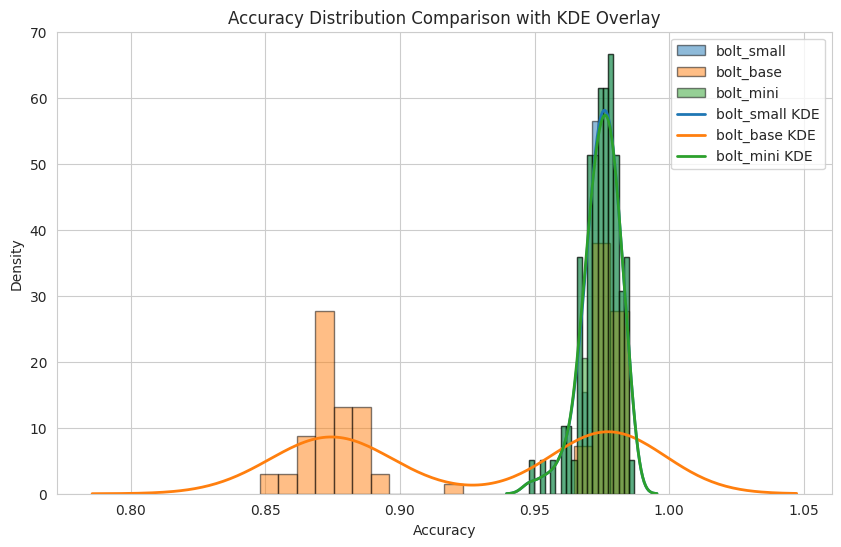

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Define custom colors
colors = {'bolt_small': '#1f77b4',
          'bolt_base': '#ff7f0e',
          'bolt_mini': '#2ca02c'}

# Plot histograms with custom colors and transparency
plt.hist(df['bolt_small_accuracy'], bins=20, alpha=0.5, label="bolt_small", color=colors['bolt_small'], edgecolor='black', density=True)
plt.hist(df['bolt_base_accuracy'], bins=20, alpha=0.5, label="bolt_base", color=colors['bolt_base'], edgecolor='black', density=True)
plt.hist(df['bolt_mini_accuracy'], bins=20, alpha=0.5, label="bolt_mini", color=colors['bolt_mini'], edgecolor='black', density=True)

# Overlay KDE curves with matching colors
sns.kdeplot(df['bolt_small_accuracy'], color=colors['bolt_small'], linewidth=2, label="bolt_small KDE")
sns.kdeplot(df['bolt_base_accuracy'], color=colors['bolt_base'], linewidth=2, label="bolt_base KDE")
sns.kdeplot(df['bolt_mini_accuracy'], color=colors['bolt_mini'], linewidth=2, label="bolt_mini KDE")

# Labels and title
plt.xlabel("Accuracy")
plt.ylabel("Density")
plt.title("Accuracy Distribution Comparison with KDE Overlay")
plt.legend()
plt.show()

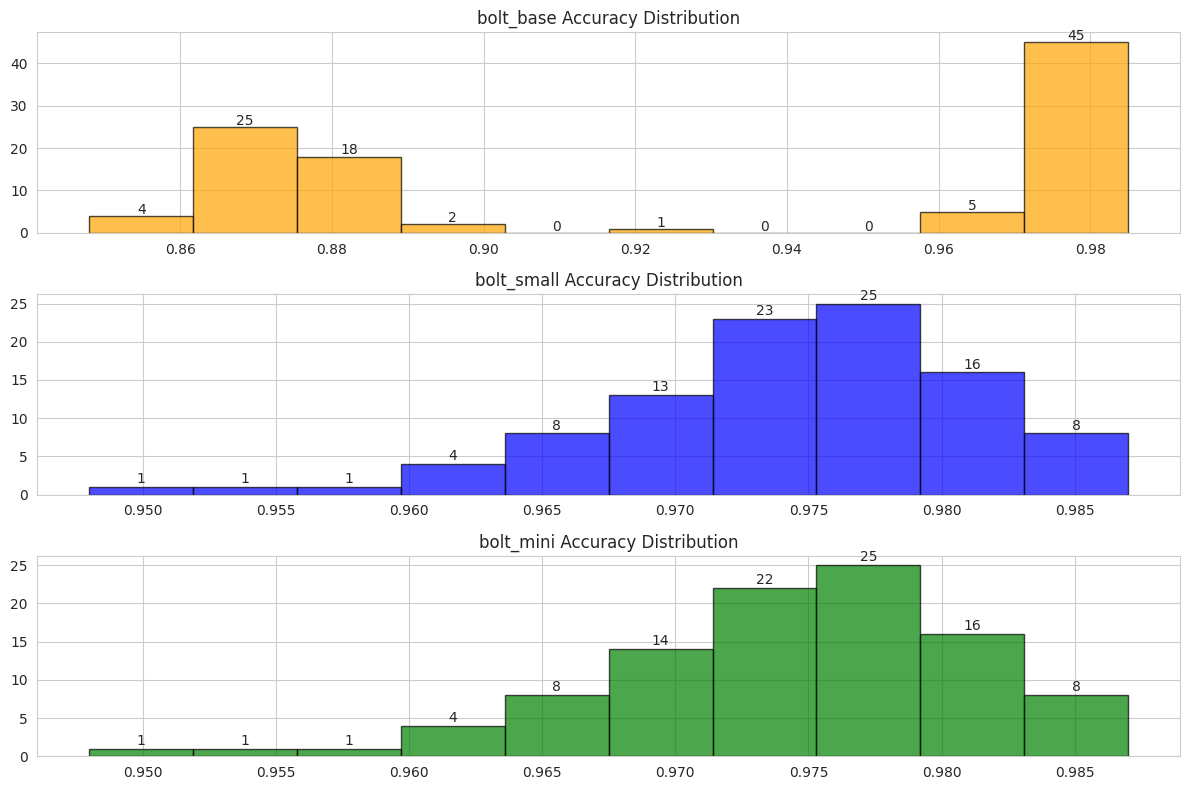

In [ ]:
# Set figure size
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Define colors and labels
colors = ['orange', 'blue', 'green']
labels = ['bolt_base',  'bolt_small', 'bolt_mini']
accuracy_cols = ['bolt_base_accuracy', 'bolt_small_accuracy', 'bolt_mini_accuracy']

# Loop through each model and plot histogram with counts
for i, col in enumerate(accuracy_cols):
    ax = axes[i]
    n, bins, patches = ax.hist(df[col], bins=10, alpha=0.7, color=colors[i], edgecolor='black')

    # Add text labels on top of each bar
    for count, bin_center in zip(n, (bins[:-1] + bins[1:]) / 2):
        ax.text(bin_center, count + 0.5, str(int(count)), ha='center', fontsize=10)

    ax.set_title(f"{labels[i]} Accuracy Distribution")

# Adjust layout and show
plt.tight_layout()
plt.show()

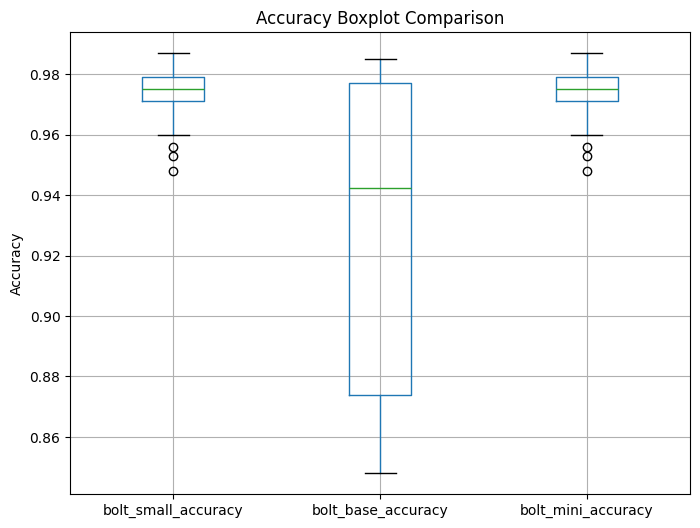

In [ ]:
# Boxplot comparison
plt.figure(figsize=(8, 6))
df[['bolt_small_accuracy', 'bolt_base_accuracy', 'bolt_mini_accuracy']].boxplot()
plt.title("Accuracy Boxplot Comparison")
plt.ylabel("Accuracy")
plt.show()

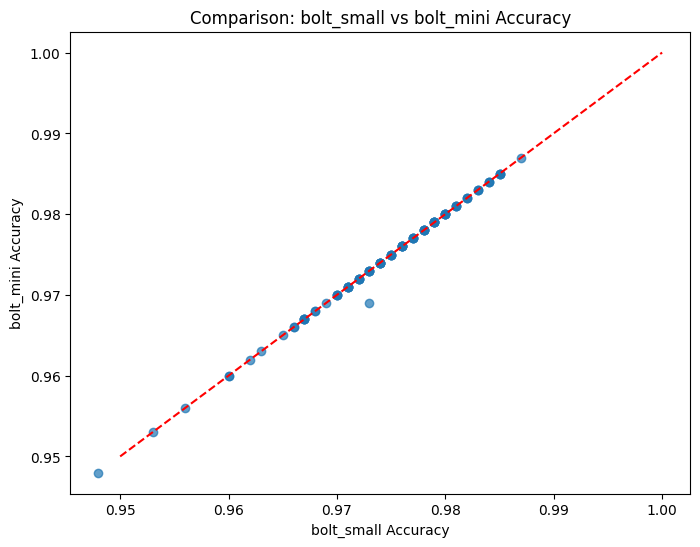

In [ ]:
# Scatter plot: bolt_mini vs bolt_small
plt.figure(figsize=(8, 6))
plt.scatter(df['bolt_small_accuracy'], df['bolt_mini_accuracy'], alpha=0.7)
plt.plot([0.95, 1], [0.95, 1], linestyle='dashed', color='red')  # Reference line
plt.xlabel("bolt_small Accuracy")
plt.ylabel("bolt_mini Accuracy")
plt.title("Comparison: bolt_small vs bolt_mini Accuracy")
plt.show()

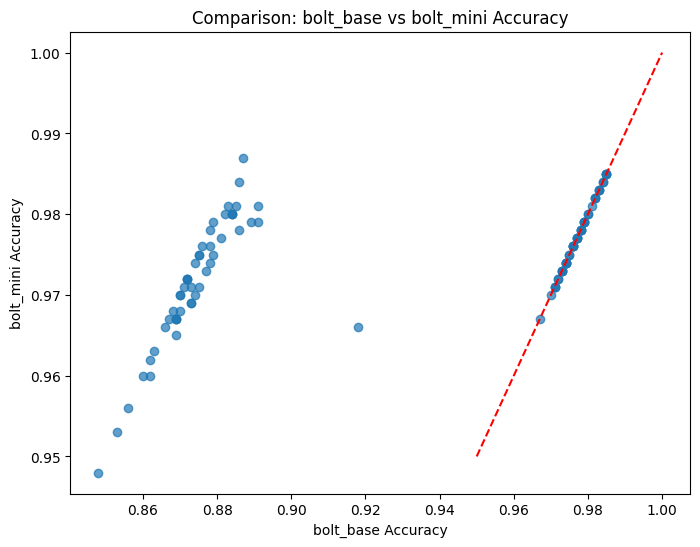

In [ ]:
# Scatter plot: bolt_mini vs bolt_base
plt.figure(figsize=(8, 6))
plt.scatter(df['bolt_base_accuracy'], df['bolt_mini_accuracy'], alpha=0.7)
plt.plot([0.95, 1], [0.95, 1], linestyle='dashed', color='red')  # Reference line
plt.xlabel("bolt_base Accuracy")
plt.ylabel("bolt_mini Accuracy")
plt.title("Comparison: bolt_base vs bolt_mini Accuracy")
plt.show()

### Finding:




Since we do zero-shot forecasting here, the whole process takes only 2-4 minutes for each model size, with smaller model taking fewer time, which is quite fast.

Chronos Bolt_small & Bolt_mini have comparable performance given 900 data points to predict 100 data points on threshold exceedance task, with Bolt_small a little better; Chronos Bolt_base performs well for the first 50 time series but relatively poor for the second 50 time series.

Remind that these 100 time series is composed as follows: the "voltage" attribute (with values around 160 to 230) for machines 1-25, "rotation" (with values around 380 to 530) for machines 26-50, "pressure" (with values around 85 to 120) for machines 51-75, and "vibration" (with values around 25 to 55) for machines 76-100. Thus, first 50 time series have larger magnitude and more variations than second 50 time series.

Chronos bolt_base has more parameters and is more capable of capturing data patterns, but if the data itself has a weak signal or more noise, the large model may mistakenly interpret the noise as a meaningful pattern, resulting in increased prediction bias. There is overfitting issue for larger model with relatively small amount of data.

But generally, the performance is quite good.